# Geometry optimisation calculation

## Run geometry optimisation

To run a geometry optimisation using aiida-mlip you need to define some inputs as AiiDA data types, to then pass to the calculation.

To start, you will need a structure to optimise. 

The structure in the example is NaCl, generated using ase.build, or alternatively one can choose one of the structures in the folder `Structures`.
The input structure in aiida-mlip needs to be saved as a StructureData type.
We can print some properties of the structure, for example the cell or the atoms sites.

In [1]:
from aiida import load_profile
load_profile()

from aiida.orm import StructureData
from ase.io import read
from ase.build import bulk


# structure = StructureData(ase=read("structures/qmof-ffeef76.cif"))
structure = StructureData(ase=bulk("NaCl", "rocksalt", 5.63))

print(f"Initial cell parameters: {structure.cell}")
print(f"Structure's atoms sites: {structure.sites}")

Initial cell parameters: [[0.0, 2.815, 2.815], [2.815, 0.0, 2.815], [2.815, 2.815, 0.0]]
Structure's atoms sites: [<Site: kind name 'Na' @ 0.0,0.0,0.0>, <Site: kind name 'Cl' @ 2.815,0.0,0.0>]


Then we need to choose a model and architecture to be used for the calculation and save it as ModelData type, a specific data type of this plugin.
In this example we use mace_mp with a model that we download from this URL: "https://github.com/stfc/janus-core/raw/main/tests/models/mace_mp_small.model", and we save the file in the cache folder (default="~/.cache/mlips/"):


In [2]:
from aiida_mlip.data.model import ModelData
uri = "https://github.com/stfc/janus-core/raw/main/tests/models/mace_mp_small.model"
model = ModelData.from_uri(uri, architecture="mace_mp", cache_dir="mlips")

If we already have the model saved in some folder we can save it as:

In [ ]:
# from aiida_mlip.data.model import ModelData
# model = ModelData.from_local("mlips/mace_mp/mace_mp_small.model", architecture="mace_mp")

Another parameter that we need to define as AiiDA type is the code. Assuming the code is saved as `janus` in the `localhost` computer, the code info that are needed can be loaded as follow:


In [3]:
from aiida.orm import load_code
code = load_code("janus@localhost")

The other inputs can be set up as AiiDA Str, Float or Bool. There is a default for every input except the structure and code. This is a list of possible inputs:

In [4]:
from aiida.orm import Str, Float, Bool
inputs = {
        "code": code,
        "model": model,
        "struct": structure,
        "arch": Str(model.architecture),
        "precision": Str("float64"),
        "device": Str("cpu"),
        "fmax": Float(0.1), 
        "vectors_only": Bool(False), 
        "fully_opt": Bool(True), 
        "metadata": {"options": {"resources": {"num_machines": 1,"num_mpiprocs_per_machine": 1}}},
    }

It's worth noting that the architecture is already defined within the model, accessible through the architecture property in the ModelData. Even if not explicitly provided as input, it will be automatically retrieved from the model.

The calculation must be set:

In [5]:
from aiida.plugins import CalculationFactory
geomoptCalc = CalculationFactory("mlip.opt")

In this case, since we are running a geometry optimisation the entry point is `mlip.opt`
Finally, run the calculation:


In [6]:
from aiida.engine import run_get_node
result, node = run_get_node(geomoptCalc, **inputs)
print("CALCULATION FINISHED")

defining outputnode
CALCULATION FINISHED


## Analyse results

`result` is a dictionary of the available results obtained from the calculation, while node contains the infor on the node where the calculation is run:


In [7]:
print(f"Printing output nodes dictionary: {result}")
print(" ")
print(f"Printing calcjob node info: {node}")


Printing output nodes dictionary: {'remote_folder': <RemoteData: uuid: 81d112c1-6775-4a0a-afaa-2e2898d42499 (pk: 11167)>, 'retrieved': <FolderData: uuid: 9e7cc1fa-dcdf-4d41-99f4-68c30d403af5 (pk: 11168)>, 'log_output': <SinglefileData: uuid: bce96025-e34c-44f5-b7e5-afabbc487332 (pk: 11169)>, 'std_output': <SinglefileData: uuid: 0e8f50cd-6138-46f4-902b-31483e4179c9 (pk: 11170)>, 'xyz_output': <SinglefileData: uuid: 89bb79e1-1109-4912-bc5d-a4f04585eaec (pk: 11171)>, 'results_dict': <Dict: uuid: 58f47b77-4309-4a0f-baac-e082532caafe (pk: 11172)>, 'traj_file': <SinglefileData: uuid: 2b10f146-fabf-4cdf-a284-3a99ac87df5f (pk: 11173)>, 'traj_output': <TrajectoryData: uuid: 16747d57-f178-4b0f-aebf-e33cee8a3346 (pk: 11174)>, 'final_structure': <StructureData: uuid: 2d2c127f-d819-4576-98cb-5fb4b683dd1a (pk: 11175)>}
 
Printing calcjob node info: uuid: 1f2c7262-a13a-4177-a748-2e02af02874d (pk: 11166) (aiida.calculations:mlip.opt)


In this case there are more outputs than the single point calculation, such as the output structure and the trajectory of the optimisation.
We can see how many steps it took to optimise:

In [8]:
print(f"The number of optimisation steps is: {result['traj_output'].numsteps}")


The number of optimisation steps is: 3


The calculation can also be interacted with through verdi cli. Use `verdi process list` to show the list of calculations.


In [ ]:
! verdi process list -a

The last calculation in the list is the last thing that was run. The PK number should correspond to the PK printed when you printed the node.
You can interact with the data through verdi commands, by writing that PK number of the calculation of interest.
Every calcjob node has a results dictionary which is outputted when running:


In [10]:
! verdi calcjob res PK

Usage: verdi calcjob res [OPTIONS] [--] CALCJOB
Try 'verdi calcjob res --help' for help.

Error: Invalid value for 'CALCJOB': no CalcJobNode found with LABEL<PK>: No result was found


With the node show command we can see the inputs and outputs of the calculation.

In [11]:
! verdi node show PK

Usage: verdi node show [OPTIONS] [NODES]...
Try 'verdi node show --help' for help.

Error: Invalid value for '[NODES]...': no Node found with LABEL<PK>: No result was found


For the geometry optimisation we are most likely interested in the final structure and the trajectory of the geometry optimisation. Let's compare the initial and final cell parameters and see if they changed.

In [13]:
node.pk

11166

In [18]:
result

{'remote_folder': <RemoteData: uuid: 81d112c1-6775-4a0a-afaa-2e2898d42499 (pk: 11167)>,
 'retrieved': <FolderData: uuid: 9e7cc1fa-dcdf-4d41-99f4-68c30d403af5 (pk: 11168)>,
 'log_output': <SinglefileData: uuid: bce96025-e34c-44f5-b7e5-afabbc487332 (pk: 11169)>,
 'std_output': <SinglefileData: uuid: 0e8f50cd-6138-46f4-902b-31483e4179c9 (pk: 11170)>,
 'xyz_output': <SinglefileData: uuid: 89bb79e1-1109-4912-bc5d-a4f04585eaec (pk: 11171)>,
 'results_dict': <Dict: uuid: 58f47b77-4309-4a0f-baac-e082532caafe (pk: 11172)>,
 'traj_file': <SinglefileData: uuid: 2b10f146-fabf-4cdf-a284-3a99ac87df5f (pk: 11173)>,
 'traj_output': <TrajectoryData: uuid: 16747d57-f178-4b0f-aebf-e33cee8a3346 (pk: 11174)>,
 'final_structure': <StructureData: uuid: 2d2c127f-d819-4576-98cb-5fb4b683dd1a (pk: 11175)>}

In [27]:
trajectory = result['traj_output'].get_step_data(0)
trajectory

(0,
 None,
 array([[0.   , 2.815, 2.815],
        [2.815, 0.   , 2.815],
        [2.815, 2.815, 0.   ]]),
 ['Na', 'Cl'],
 array([[0.   , 0.   , 0.   ],
        [2.815, 0.   , 0.   ]]),
 None)

In [20]:
from aiida.orm import load_node

print(f"Initial cell parameters: {structure.cell}")
# result_node = load_node(node.pk)
print(f"Final cell parameters: {result['final_structure'].cell}")

Initial cell parameters: [[0.0, 2.815, 2.815], [2.815, 0.0, 2.815], [2.815, 2.815, 0.0]]
Final cell parameters: [[-1.2131772475387e-19, 2.8438848145858, 2.8438848145858], [2.8438848145858, -7.6273557405715e-18, 2.8438848145858], [2.8438848145858, 2.8438848145858, 1.4476268929484e-17]]


## Plot energies and visualise provenance graph

Now let's analyse the steps of the optimisation. We'll run singlepoint calculation on every steps to see how the energy changed. We'll also use this to visualise a complex provenance graph with more calculations connected.
Note the outputs of the calculation can be called either by using the load_node function when the Pk is known or directly with the outputs attribute of the calcjobe node.
Note also that we use the `calcfunction` decorator get the single structures from the `TrajectoryData`

In [29]:
from aiida.orm import load_node
from aiida.engine import calcfunction


traj = node.outputs.traj_output
# traj = load_node(node.pk)
    
@calcfunction
def prepare_struct_inputs(traj, index):
    return traj.get_step_structure(index.value)

uri = "https://github.com/stfc/janus-core/raw/main/tests/models/mace_mp_small.model"
model = ModelData.from_uri(uri, architecture="mace_mp", cache_dir="mlips")
list_of_nodes = []


inputs = {
    "code": code,
    "model": model,
    "precision": Str("float64"),
    "device": Str("cpu"),
    "metadata": {"options": {"resources": {"num_machines": 1,"num_mpiprocs_per_machine": 1}}},
}
    
for index in range(traj.numsteps):
    print(index)
    singlepointCalc = CalculationFactory("mlip.sp")
    struc = prepare_struct_inputs(traj, index)
    inputs['struct']=struc
    result, node = run_get_node(singlepointCalc, **inputs)
    list_of_nodes.append(node)
print("calculations ended")

0
1
2
calculations ended


Let's print the list of alcjob nodes that we just created

In [30]:
list_of_nodes

[<CalcJobNode: uuid: f5c7b374-3ffc-4230-9871-e2ab2ac01d29 (pk: 11191) (aiida.calculations:mlip.sp)>,
 <CalcJobNode: uuid: 2ca8d1d7-fe88-47fd-8000-4a220e17c717 (pk: 11203) (aiida.calculations:mlip.sp)>,
 <CalcJobNode: uuid: 3123d365-e690-4281-b01f-6859d45e4fc3 (pk: 11215) (aiida.calculations:mlip.sp)>]

Now we can use it for getting the energies in every step and plotting them.
(a better alternative to the list of nodes might be to use a AiiDA group, see high-throughput-screening tutorial)

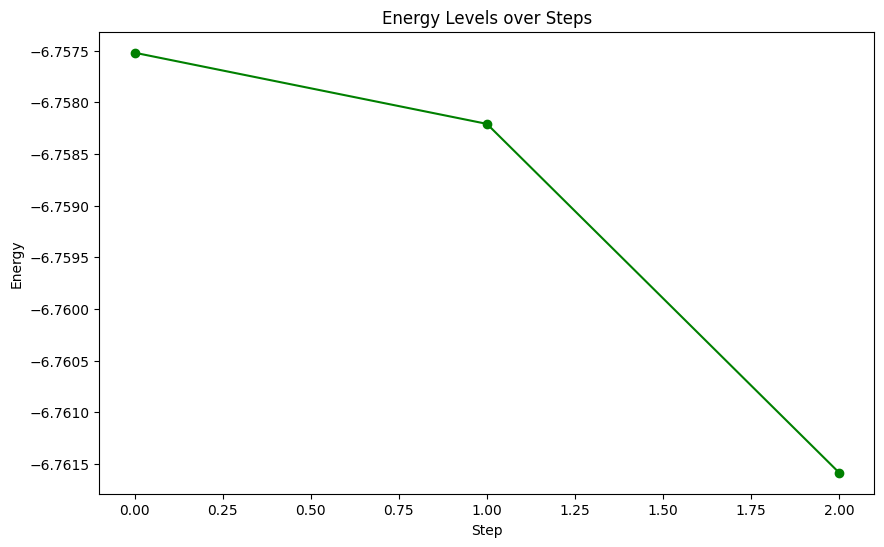

In [31]:
import matplotlib.pyplot as plt

steps = []
energies = []

# Loop through each node to extract step number and energy level
for step, node in enumerate(list_of_nodes):
    energy = node.outputs.results_dict.get_dict()['info']['mace_mp_energy']
    steps.append(step)
    energies.append(energy)

# Plotting the energy levels over steps
plt.figure(figsize=(10, 6))
plt.plot(steps, energies, marker='o', linestyle='-', color='g')
plt.title('Energy Levels over Steps')
plt.xlabel('Step')
plt.ylabel('Energy')
plt.show()


We can see that the energy decreased, which is what we want in a geometry optimisation process.

Now let's generate the provenance graph. (Insert PK number of the TrajectoryData in the code)

In [32]:
! verdi node graph generate PK

Usage: verdi node graph generate [OPTIONS] [ROOT_NODES]...
Try 'verdi node graph generate --help' for help.

Error: Invalid value for '[ROOT_NODES]...': no Node found with LABEL<PK>: No result was found


The provenance graph shows both the calculation that created the `TrajectoryData` and the calculations that we run using the structures in the `TrajectoryData`.
This is made possible by the use of the `calcfunction` decorator that we used. If we had not used it, the graph would stop a the `TrajectoryData` and the other `Singlepoint` calculations would be independent.